# Recommendation System Project: IBM Community

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import seaborn as sns
sns.set()
%matplotlib inline


df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()



,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [128]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` Are there any missing values? If so, provide a count of missing values. If there are missing values in `email`, assign it the same id value `"unknown_user"`.

In [129]:
# Some interactions do not have a user associated with it, assume the same user.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   article_id  45993 non-null  float64
 1   title       45993 non-null  object 
 2   email       45976 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [130]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doc_body         1042 non-null   object
 1   doc_description  1053 non-null   object
 2   doc_full_name    1056 non-null   object
 3   doc_status       1056 non-null   object
 4   article_id       1056 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 41.4+ KB


In [131]:
#columns and rows
df.shape

(45993, 3)

In [132]:
#checking for missing values and output results
print("In df dataset specifically, there are {} unique values for article_id".format(df.article_id.nunique()))
print("In df_content dataset specifically, there are {} unique values for article_id".format(df_content.article_id.nunique()))



In df dataset specifically, there are 714 unique values for article_id
In df_content dataset specifically, there are 1051 unique values for article_id


`2.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.

In [133]:
# What are the descriptive statistics of the number of articles a user interacts with?


#number of articles per user (count of article_id grouped by user)
user_article_counts = df.groupby('email').article_id.count().sort_values(ascending=False)

#descriptive statistics
user_article_stats = user_article_counts.describe()

#median and max views
median_val = df.groupby('email')['article_id'].count().median() # 50% of individuals interact with 3 number of articles or fewer.
max_views_by_user = df.groupby('email')['article_id'].count().max() # The maximum number of user-article interactions by any 1 user is 364.

In [134]:
user_interacts = df.groupby('email')['article_id'].count()
user_interacts

email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
                                            ..
ffc6cfa435937ca0df967b44e9178439d04e3537     2
ffc96f8fbb35aac4cb0029332b0fc78e7766bb5d     4
ffe3d0543c9046d35c2ee3724ea9d774dff98a32    32
fff9fc3ec67bd18ed57a34ed1e67410942c4cd81    10
fffb93a166547448a0ff0232558118d59395fecd    13
Name: article_id, Length: 5148, dtype: int64

In [135]:
user_interacts.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

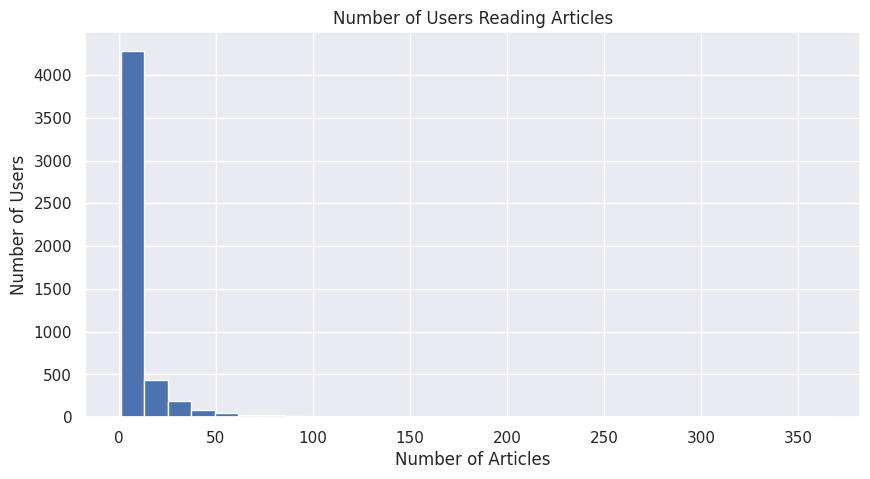

In [136]:
# Create a plot of the number of articles read by each user

plt.figure(figsize=(10, 5))
user_article_counts.hist(bins=30)
plt.xlabel('Number of Articles')
plt.ylabel('Number of Users')
plt.title('Number of Users Reading Articles')
plt.grid(True)
plt.show()

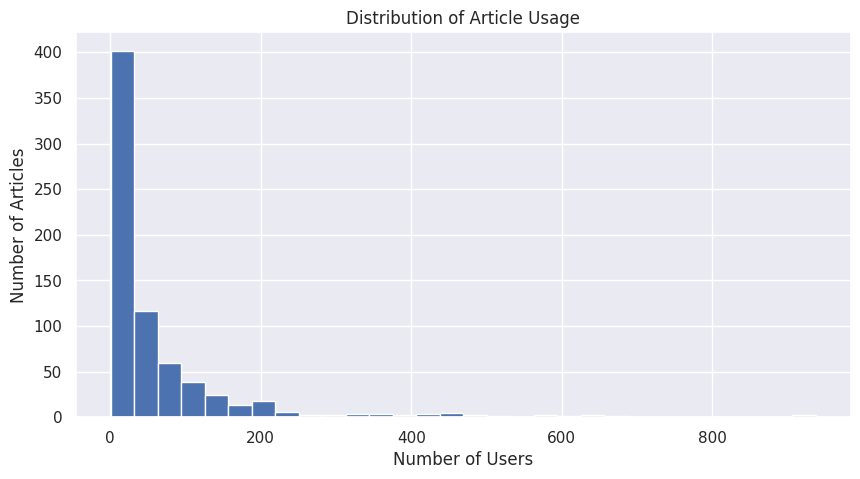

In [137]:
# Create a plot of the number of times each article was read

article_user_counts = df.groupby('article_id')['email'].count()
plt.figure(figsize=(10, 5))
article_user_counts.hist(bins=30)
plt.xlabel('Number of Users')
plt.ylabel('Number of Articles')
plt.title('Distribution of Article Usage')
plt.grid(True)
plt.show()

In [138]:
#Here I am looking for duplicate articles
df_content.head(5)

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [139]:
#Here I am deleting any rows that have the same article_id then keeping only the first observation based on reviewer suggestion

df_content.drop_duplicates(subset=['article_id'], keep='first', inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [140]:
#I am looking at how many columns and rows the dataset has now
print(df.shape)
print(df_content.shape)

(45993, 3)
(1051, 5)


In [141]:
#a.number of unique articles with at least one interaction
unique_articles = df.article_id.nunique()

#b.total number of unique articles (from title + article_id)
total_articles = df_content.article_id.nunique()

#c.number of unique users (I have also excluded nulls)
unique_users = df.email.nunique()

#d.total number of user-article interactions
user_article_interactions = df.shape[0]

#outputting results
{
    "Unique Articles (with interaction)": unique_articles,
    "Total Articles in Dataset": total_articles,
    "Unique Users (non-null)": unique_users,
    "Total User-Article Interactions": user_article_interactions
}

{'Unique Articles (with interaction)': 714,
 'Total Articles in Dataset': 1051,
 'Unique Users (non-null)': 5148,
 'Total User-Article Interactions': 45993}

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [142]:
#this is the most viewed article_id
df.article_id.value_counts().head(1)

article_id
1429.0    937
Name: count, dtype: int64

In [143]:
#most viewed article should be a string with one value following the decimal 
most_viewed_article_id = str(df.article_id.value_counts().index[0])

#most viewed article in the dataset
max_views = df.article_id.value_counts().iloc[0]

In [144]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column


def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [148]:
#checking the format types for the test to see which ones I need to adjust
print(f"{'median_val.':30}{median_val:<8}{type(median_val).__name__}")
print(f"{'max_views_by_user.':30}{max_views_by_user:<8}{type(max_views_by_user).__name__}")
print(f"{'unique_articles':30}{unique_articles:<8}{type(unique_articles).__name__}")
print(f"{'total_articles':30}{total_articles:<8}{type(total_articles).__name__}")
print(f"{'unique_users.':30}{unique_users:<8}{type(unique_users).__name__}")
print(f"{'user_article_interactions':30}{user_article_interactions:<8}{type(user_article_interactions).__name__}")
print(f"{'most_viewed_article_id.':30}{most_viewed_article_id:<8}{type(most_viewed_article_id).__name__}")
print(f"{'max_views.':30}{max_views:<8}{type(max_views).__name__}")


median_val.                   3.0     float64
max_views_by_user.            364     int64
unique_articles               714     int
total_articles                1051    int
unique_users.                 5148    int
user_article_interactions     45993   int
most_viewed_article_id.       1429.0  str
max_views.                    937     int64


In [149]:
median_val = int(round(float(median_val)))
max_views_by_user = int(max_views_by_user)
max_views = int(max_views)

In [ ]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

In [159]:
#Yay! making the correct results look neater and match reviewer answers
print(f"{'median_val.':30}{median_val:<8}{type(median_val).__name__}")
print(f"{'max_views_by_user.':30}{max_views_by_user:<8}{type(max_views_by_user).__name__}")
print(f"{'unique_articles':30}{unique_articles:<8}{type(unique_articles).__name__}")
print(f"{'total_articles':30}{total_articles:<8}{type(total_articles).__name__}")
print(f"{'unique_users.':30}{unique_users:<8}{type(unique_users).__name__}")
print(f"{'user_article_interactions':30}{user_article_interactions:<8}{type(user_article_interactions).__name__}")
print(f"{'most_viewed_article_id.':30}{most_viewed_article_id:<8}{type(most_viewed_article_id).__name__}")
print(f"{'max_views.':30}{max_views:<8}{type(max_views).__name__}")


median_val.                   3       int
max_views_by_user.            364     int
unique_articles               714     int
total_articles                1051    int
unique_users.                 5148    int
user_article_interactions     45993   int
most_viewed_article_id.       1429.0  str
max_views.                    937     int


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In this project, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [160]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df['title'].value_counts().index.tolist()[:n]
    top_articles = [str(i) for i in top_articles]
    
    return top_articles #Returning the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    
    '''
    top_articles = df['article_id'].value_counts().index.tolist()[:n]
    top_articles = [str(i) for i in top_articles]

    return top_articles #Returning the top article ids


In [161]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [162]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [165]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    

    '''

    df_count = df.groupby(['user_id', 'article_id']).count().reset_index()

    #organizing users as rows & articles as columns
    user_item = df_count.pivot_table(values='title', 
                                     index='user_id', 
                                     columns='article_id')

    #filling in NaNs with 0 so looks neater
    user_item = user_item.fillna(0)

    #converting counts to binary --> 1 if interacted, else 0
    user_item = user_item.map(lambda x: 1 if x > 0 else 0)

    return user_item

user_item = create_user_item_matrix(df)

In [166]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [168]:
def find_similar_users(user_id, user_item=user_item):
    '''
  
    
    '''
    #similarity tests
    dot_prod_users = user_item.dot(np.transpose(user_item))
    
    #sorting
    sim_users = dot_prod_users[user_id].sort_values(ascending = False)
    
     #returning a list of the users in order from most to least similar
    most_similar_users = sim_users.index.tolist()
    
  
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar

In [169]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 46, 4201, 395]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [170]:
def get_article_names(article_ids, df=df):
    '''

    '''
    article_names = []

    for idx in article_ids:
        article_names.append(df[df['article_id']==float(idx)].max()['title'])
    
    return article_names 


def get_user_articles(user_id, user_item=user_item):
    '''
   
    '''
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.astype('str')
    
    article_names = []

    for idx in article_ids:
        article_names.append(df[df['article_id']==float(idx)].max()['title']) # need to use df instead of df_content as it only has 1051 rows
    
    return article_ids, article_names #ids and names


def user_user_recs(user_id, m = 10):
    '''
   
    
    '''
    recs = np.array([]) 
    
    user_articles_seen = get_user_articles(user_id)[0] 
    closest_users = find_similar_users(user_id) #closest match
    
    for others in closest_users:
        
        others_articles_seen = get_user_articles(others)[0] 
        new_recs = np.setdiff1d(others_articles_seen, user_articles_seen, assume_unique=True) 
        recs = np.unique(np.concatenate([new_recs, recs], axis = 0)) 

        if len(recs) > m-1:
            break
            
    recs = recs[:m]
    recs.tolist()
    
    return recs     

In [171]:
#checking the results
get_article_names(user_user_recs(1, 10)) #returning 10 recommendations for user 1

['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

In [172]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the user_user_recs function from above.

Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.

Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be what would be obtained from the top_articles function you wrote earlier.

In [173]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    

     
    '''
    
    neighbors_df = pd.DataFrame(columns=['neighbor_id', 'similarity'])
    
    #equal to user_item starting from 1
    neighbors_df['neighbor_id'] = user_item.index-1
    
    #similarity scoring
    dot_prod_users = user_item.dot(np.transpose(user_item))
    neighbors_df['similarity'] = dot_prod_users[user_id]
    

    interacts_df = df.user_id.value_counts().rename_axis('neighbor_id').reset_index(name='num_interactions')
    
    neighbors_df = pd.merge(neighbors_df, interacts_df, on='neighbor_id', how='outer')
    #sorting 
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending = False)

    neighbors_df = neighbors_df.reset_index(drop=True)

    neighbors_df = neighbors_df[neighbors_df.neighbor_id != user_id]
    
    return neighbors_df 


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
  
   
    '''
    recs = np.array([]) 
    
    user_articles_ids_seen, user_articles_names_seen = get_user_articles(user_id, user_item) #article ids seen by our user
    closest_neighs = get_top_sorted_users(user_id, df, user_item).neighbor_id.tolist() # neighbour user ids closest to our user
    
    for neighs in closest_neighs:
        
        neigh_articles_ids_seen, neigh_articles_names_seen = get_user_articles(neighs, user_item) # articles seen by others like our user
        new_recs = np.setdiff1d(neigh_articles_ids_seen, user_articles_ids_seen, assume_unique=True) #find those not seen by user
        recs = np.unique(np.concatenate([new_recs, recs], axis = 0)) # concate arrays and only return unique values

        if len(recs) > m-1:
            break
            
    recs = recs[:m]
    recs = recs.tolist() 
    
    rec_names = get_article_names(recs, df=df)
    
    return recs, rec_names

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [174]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1024.0', '1085.0', '109.0', '1150.0', '1151.0', '1152.0', '1153.0', '1154.0', '1157.0', '1160.0']

The top 10 recommendations for user 20 are the following article names:
['using deep learning to reconstruct high-resolution audio', 'airbnb data for analytics: chicago listings', 'tensorflow quick tips', 'airbnb data for analytics: venice calendar', 'airbnb data for analytics: venice listings', 'airbnb data for analytics: venice reviews', 'airbnb data for analytics: vienna calendar', 'airbnb data for analytics: vienna listings', 'airbnb data for analytics: washington d.c. listings', 'analyze accident reports on amazon emr spark']


In [175]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0].neighbor_id # Find the user that is most similar to user 1 
user2_6th_sim = get_top_sorted_users(2).iloc[5].neighbor_id # Find the 6th most similar user to user 2
user131_10th_sim = get_top_sorted_users(131).iloc[9].neighbor_id # Find the 10th most similar user to user 131

In [ ]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim,
    'The user that is the 6th most similar to user 2.': user2_6th_sim,
    'The user that is the 10th most similar to user 131.': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

Answer:

For a new user, there is no interaction history, so cannot use collaborative filtering methods like user-user or item-item recommendations. Instead, it is best to rely on popularity-based recommendations.

For a new user, I would rely on popularity-based recommendations.
The best approach is to recommend the top articles based on the number of total interactions. For example, the most popular articles across all users. This is already implemented in the get_top_article_ids function.

A better method might be content-based recommendations if we know the user's interests, job title, or past browsing behavior (even outside this platform). Then, we could match them to articles with similar content.

However, until then, popularity-based ranking is the best approach for cold-start (new) users is my recommendation.
Top articles as no user history, only can use user-user history till they start having user-item iteractions

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [ ]:
# What would your recommendations be for this new user 0?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)
print(new_user_recs)



In [33]:
assert set(new_user_recs) == {'1314', '1429', '1293', '1427', '1162', '1364', '1304', '1170', '1431', '1330'}, \
    "Oops! It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right! Nice job!")

That's right! Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to recommend similar articles that are possibly related. One way we can find article relationships is by clustering text about those articles.  Let's consider content to be the article **title**, as it is the only text we have available. One point to highlight, there isn't one way to create a content based recommendation, especially considering that text information can be processed in many ways.  

`1.` Use the function bodies below to create a content based recommender function `make_content_recs`. We'll use TF-IDF to create a matrix based off article titles, and use this matrix to create clusters of related articles. You can use this function to make recommendations of new articles.

In [42]:
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [43]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [44]:
# unique articles
df_unique_articles = df[['article_id', 'title']].drop_duplicates().reset_index(drop=True)

In [45]:
# Create a vectorizer using TfidfVectorizer and fit it to the article titles
max_features = 200
max_df = 0.75
min_df = 5

vectorizer = TfidfVectorizer(
    max_df=max_df,
    min_df=min_df,
    stop_words="english",
    max_features=max_features,
)
print("Running TF-IDF")
X_tfidf = vectorizer.fit_transform(df_unique_articles['title']) # Fit the vectorizer to the article titles

print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

lsa = make_pipeline(TruncatedSVD(n_components=50), Normalizer(copy=False))
X_lsa = X_lsa = lsa.fit_transform(X_tfidf) # Fit the LSA model to the vectorized article titles
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Running TF-IDF
n_samples: 714, n_features: 125
Explained variance of the SVD step: 76.0%


Text(0.5, 0, 'Number of clusters')

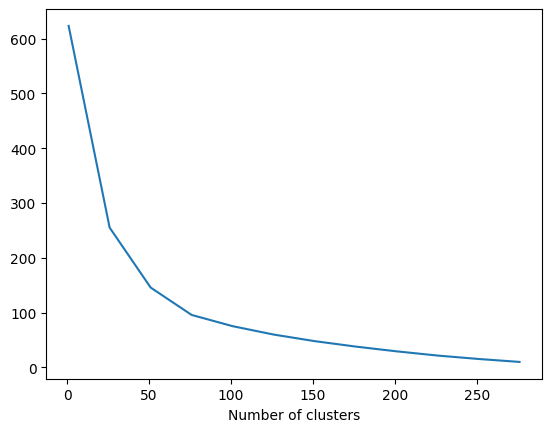

In [46]:
# Let's map the inertia for different number of clusters to find the optimal number of clusters
# We'll plot it to see the elbow
inertia = []
clusters = 300
step = 25
max_iter = 50
n_init = 5
random_state = 42
for k in range(1, clusters, step):
    kmeans = KMeans(
        n_clusters=k,
        max_iter=max_iter,
        n_init=n_init,
        random_state=random_state,
    ).fit(X_lsa)
    # inertia is the sum of squared distances to the closest cluster center
    inertia.append(kmeans.inertia_)
plt.plot(range(1, clusters, step), inertia)
plt.xlabel('Number of clusters')

There appears to be an elbow about 50, so we'll use 50 clusters.

In [49]:
n_clusters = 50
kmeans = KMeans(
    n_clusters=n_clusters,
    max_iter=max_iter,
    n_init=n_init,
    random_state=random_state,
).fit(X_lsa)

In [51]:
# create a new column `title_cluster` and assign it the kmeans cluster labels
# First we need to map the labels to df_unique_articles article ids and then apply those to df
article_cluster_map = dict(zip(df_unique_articles['article_id'], kmeans.labels_)) # Map article_id to cluster label
df['title_cluster'] = df['article_id'].map(article_cluster_map) # apply map to create title clusters

In [52]:
# Let's check the number of articles in each cluster
cluster_distribution = np.array(np.unique(kmeans.labels_, return_counts=True)).T
cluster_distribution[:10] 

array([[ 0, 12],
       [ 1, 20],
       [ 2, 23],
       [ 3, 21],
       [ 4,  9],
       [ 5, 70],
       [ 6, 32],
       [ 7, 37],
       [ 8, 13],
       [ 9, 10]])

In [53]:
def get_ranked_article_unique_counts(article_ids, df=df):
    """
   
    """
    filtered_df = df[df['article_id'].isin(article_ids)]
    article_counts = filtered_df.groupby('article_id')['user_id'].nunique()
    sorted_counts = article_counts.sort_values(ascending=False)
    return list(sorted_counts.items())

def get_similar_articles(article_id, df=df):
    """
    INPUT:
    article_id - (int) an article id 
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    article_ids - (list) a list of article ids that are in the same title cluster
    
    Description:
    Returns a list of the article ids that are in the same title cluster
    """
     # Your code here
    title_cluster = df[df['article_id'] == article_id]['title_cluster'].values[0]
    articles_in_cluster = df[df['title_cluster'] == title_cluster]['article_id'].unique().tolist()
    
    if article_id in articles_in_cluster:
        articles_in_cluster.remove(article_id)
    
    return articles_in_cluster
    
   

In [55]:
def make_content_recs(article_id, n, df=df):
    """
    INPUT:
    article_id - (int) an article id
    n - (int) the number of recommendations you want similar to the article id
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    n_ranked_similar_articles - (list) a list of article ids that are in the same title cluster ranked
                                by popularity
    n_ranked_article_names - (list) a list of article names associated with the list of article ids
    
    Description:
    Returns a list of the n most ranked similar articles to a given article_id based on the title
    cluster in df. Rank similar articles using the function get_ranked_article_unique_counts.
    """
    # Your code here
    
    similar_articles = get_similar_articles(article_id, df)
    ranked_similar_articles = get_ranked_article_unique_counts(similar_articles, df)
    top_article_ids = [aid for aid, _ in ranked_similar_articles[:n]]
    
    article_names = df[df['article_id'].isin(top_article_ids)][['article_id', 'title']].drop_duplicates()
    title_map = dict(zip(article_names['article_id'], article_names['title']))
    n_ranked_article_names = [title_map[aid] for aid in top_article_ids]
    
    return top_article_ids, n_ranked_article_names

#testing
rec_article_ids, rec_article_titles = make_content_recs(25, 10)
rec_article_ids, rec_article_titles
        

([1025, 101, 975, 766, 547, 132, 878, 92, 693, 346],
 ['data tidying in data science experience',
  'how to choose a project to practice data science',
  'the data science process',
  'making data science a team sport',
  'trust in data science',
  'collecting data science cheat sheets',
  '10 data science podcasts you need to be listening to right now',
  '9 mistakes to avoid when starting your career in data science',
  'better together: spss and data science experience',
  'fighting gerrymandering: using data science to draw fairer congressional districts'])

In [58]:
# Test out your content recommendations given artice_id 25
rec_article_ids, rec_article_titles = make_content_recs(25, 10)
print(rec_article_ids)
print(rec_article_titles)

[1025, 101, 975, 766, 547, 132, 878, 92, 693, 346]
['data tidying in data science experience', 'how to choose a project to practice data science', 'the data science process', 'making data science a team sport', 'trust in data science', 'collecting data science cheat sheets', '10 data science podcasts you need to be listening to right now', '9 mistakes to avoid when starting your career in data science', 'better together: spss and data science experience', 'fighting gerrymandering: using data science to draw fairer congressional districts']


In [61]:
assert len({1025, 593, 349, 821, 464, 29, 1042, 693, 524, 352}.intersection(set(rec_article_ids))) > 0, "Oops! Your the make_content_recs function doesn't work quite how we expect."

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function? What other text data would be useful to help make better recommendations besides the article title?

**Write an explanation of your content based recommendation system here.**

My content-based recommendation system uses article titles to identify and recommend articles that are similar to a given one. Below is a brief breakdown of how my system works:

1.Preprocessing with TF-IDF: I use TfidfVectorizer to convert article titles into numerical feature vectors.

2.Dimensionality Reduction with LSA: I apply TruncatedSVD followed by Normalizer to reduce the dimensionality of the TF-IDF matrix capturing the main semantic structure while reducing noise.

3.Clustering with KMeans: I cluster the articles using KMeans into 50 clusters based on the elbow method. Each article is assigned to a title_cluster grouping it with similar titles.

4.Recommendation Logic: Given an article_id, I find its cluster and return other articles from the same cluster.These similar articles are ranked based on the number of unique user interactions (get_ranked_article_unique_counts) to prioritize popularity.The top n most popular articles in the cluster (excluding the input) are returned.

The possible improvements I propose are:
a)to include Full Article Content. Currently,I only use titles which are often short and vague.Including abstracts, summaries, or full article bodies would provide a richer basis for semantic understanding.

b)use contextual word embeddings from BERT can capture deeper semantic similarity between titles or article content

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to users.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [62]:
# quick look at the matrix
user_item.head()

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) on the user-item matrix.  Use the cell to perform SVD.

In [64]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, recall_score, accuracy_score
# Using the full number of components which equals the number of columns
svd = TruncatedSVD(n_components=len(user_item.columns), n_iter=5, random_state=42)

u = svd.fit_transform(user_item)
v = svd.components_
s = svd.singular_values_ 
print('u', u.shape)
print('s', s.shape)
print('vt', v.shape)

u (5149, 714)
s (714,)
vt (714, 714)


`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain better metrics when making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how our metrics improve as we increase the number of latent features.

Text(0.5, 1.0, 'Metrics vs. Number of Latent Features')

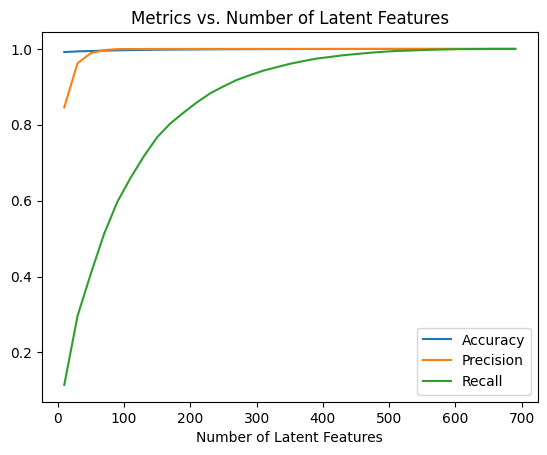

In [65]:
num_latent_feats = np.arange(10, 700+10, 20)
metric_scores = []

for k in num_latent_feats:
    # restructure with k latent features
    u_new, vt_new = u[:, :k], v[:k, :]
    
    # take dot product
    user_item_est = abs(np.around(np.dot(u_new, vt_new))).astype(int)
    # make sure the values are between 0 and 1
    user_item_est = np.clip(user_item_est, 0, 1)
    
    # total errors and keep track of them
    acc = accuracy_score(user_item.values.flatten(), user_item_est.flatten())
    precision = precision_score(user_item.values.flatten(), user_item_est.flatten())
    recall = recall_score(user_item.values.flatten(), user_item_est.flatten())
    metric_scores.append([acc, precision, recall])
    
    
plt.plot(num_latent_feats, metric_scores, label=['Accuracy', 'Precision', 'Recall'])
plt.legend()
plt.xlabel('Number of Latent Features')
plt.title('Metrics vs. Number of Latent Features')

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations. Given the plot above, what would you pick for the number of latent features and why?




**Provide your response here.**

When evaluating our recommendation system after splitting into training and test data:

Predicted users: The model can successfully make recommendations for 20 test-set users who already have historical interaction data in the training set.

Unpredicted users (cold start): For 662 test-set users, no predictions are possible because they are new to the system and have no recorded activity in the training data.

Predicted articles: There are 574 articles for which the model can produce predictions in the test set.

Unpredicted articles (cold start): The cold start problem does not affect any articles in this split—0 articles are entirely unseen in the training set.

`5.` Using 200 latent features and the values of U, S, and V transpose we calculated above, create an article id recommendation function that finds similar article ids to the one provide.

Create a list of 10 recommendations that are similar to article with id 4.  The function should provide these recommendations by finding articles that have the most similar latent features as the provided article.

In [67]:
def get_svd_similar_article_ids(article_id, vt, user_item=user_item, include_similarity=False):
    """
    INPUT:
    article_id - (int) an article id
    vt - (numpy array) vt matrix from SVD
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output
    
    OUTPUT:
    article_ids - (list) a list of article ids that are in the same title cluster
    
    Description:
    Returns a list of the article ids similar using SVD factorization
    """
    # Find the index of the article_id
    article_ids = user_item.columns.tolist()
    if article_id not in article_ids:
        return []

    idx = article_ids.index(article_id)
    # Find the cosine similarity of all articles
    # Hint: vt should be transposed before passing to cosine_similarity to get a 714 x 714 matrix 
    cos_sim = cosine_similarity(vt.T)
    
    # Get similarities only for the cos_sim of the article_idx
    sim_scores = list(enumerate(cos_sim[idx]))
    # Sort and return the articles, don't include the own article
    sim_scores_sorted = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:]
    
    most_similar_items = [article_ids[i] for i, _ in sim_scores_sorted]
        
    if include_similarity:
        return [[article_ids[i], score] for i, score in sim_scores_sorted] # return a list of lists with [[similar_article_id, similarity], ...]
    return most_similar_items

In [68]:
# Create a vt_new matrix with 200 latent features
k = 200
vt_new = v[:k, :]

In [69]:
# What is the article name for article_id 4?
print("Current article:", get_article_names([4], df=df)[0])

Current article: analyze ny restaurant data using spark in dsx


In [70]:
# What are the top 10 most similar articles to article_id 4?
rec_articles = get_svd_similar_article_ids(4, vt_new, user_item=user_item)[:10]
rec_articles

[1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132]

In [71]:
# What are the top 10 most similar articles to article_id 4?
get_article_names(rec_articles, df=df)

['use spark r to load and analyze data',
 'collecting data science cheat sheets',
 '10 powerful features on watson data platform, no coding necessary',
 'notebooks: a power tool for data scientists',
 'country statistics: crude oil - proved reserves',
 'country statistics: crude oil - exports',
 'top analytics tools in 2016',
 'advancements in the spark community',
 'airbnb data for analytics: paris calendar',
 'airbnb data for analytics: athens reviews']

In [73]:
assert set(rec_articles) == {1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132}, "Oops! Your the get_svd_similar_article_ids function doesn't work quite how we expect."
print("That's right!  Great job!")

That's right!  Great job!


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make above are an improvement to how users currently find articles, either by Sections 2, 3, or 4? Add any tradeoffs between each of the methods, and how you could leverage each type for different situations including new users with no history, recently new users with little history, and users with a lot of history. 

**Your response here.**
The recommendations for article ID 4 (analyze my restaurant data using spark in dsx) appear coherent and relevant. Many of the top-10 similar articles involve Spark, data analysis, or data science tools.

This shows that latent features learned by the SVD algorithm successfully captured hidden similarities that aren’t based purely on titles or interaction counts.

Overall, no one model fits all scenarios. The best system would be a hybrid recommender that maybe starts with popular/content-based for new users, then switches to user-user once a few interactions occur, and then ransitions to SVD/matrix factorization for experienced users.

I have broken down the following methods based on tradeoffs:
Most Popular (section 2): it is simple, effective for cold starts; however, it is generic and not personalized. Better for new users

User-User Collaborative (section 3): it captures personalization based on behavior; however, it has sparse matrix issues and doesn't generalize well to new items; Better for users with some interaction history

Content-Based (section 4): it works for new articles and interpretable; however, it ignores user preferences and relies on quality of text features; Better for articles with good metadata


To evaluate how well the recommendation engine works in practice, design a structured A/B test (randomized controlled trial) using the below steps:

1.define the objective and metrics

-primary metric: measures the proportion of recommended articles that users actually click on.

-secondary metrics: engagement time (average time spent on recommended articles), conversion rate (signing up for related services), and user satisfaction scores (from surveys or ratings).



2.set up control and treatment groups

-control group: eceives recommendations using the current baseline method (such as most popular articles).

-treatment Group: receives recommendations generated by our new engine.

Users should be randomly assigned to ensure fairness and avoid selection bias.

3.execution of the experiment

-run the test for a statistically significant period such as 2–4 weeks to capture different user behaviors and avoid seasonality bias.

-ensure that users in both groups have similar activity levels and demographics to make results comparable.

4.data collection & analysis

-compare performance across groups using statistical tests such as t-tests or chi-squared tests to determine if differences are significant.

-examine whether certain subgroups (new vs. returning users) benefit more from the recommendations.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendation Systems project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [76]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/local/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/venv/lib/python3.10/site-packages/nbconvert/__main__.py", line 5, in <module>
    main()
  File "/opt/venv/lib/python3.10/site-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/opt/venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/venv/lib/python3.10/site-packages/nbconvert/nbconvertapp.py", line 420, in start
    self.convert_notebooks()
  File "/opt/venv/lib/python3.10/site-packages/nbconvert/nbconvertapp.py", line 582, in convert_notebooks
    raise ValueError(msg)
ValueError: Please specify an output format with '--to <format>'.
The following formats are available: ['a

1